In [4]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.impute import SimpleImputer

from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler

In [5]:
base_path = os.path.dirname(os.getcwd())
data_dir = os.path.join(base_path, "data", "processed", "Toys_and_Games")
DATA_PATH = os.path.join(data_dir, "toys_and_games.parquet")

data = pd.read_parquet(DATA_PATH)

X = data.drop('class', axis=1)
y = data['class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)



In [6]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=0))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('text', TfidfVectorizer(), 'cleaned_text'),
        ('numeric', numeric_transformer, ['overall', 'helpfulness_ratio']) 
    ],
    remainder='drop'
)

pipeline = Pipeline([("preprocessor", preprocessor), ("sampler", RandomUnderSampler(random_state=42)), ("model", MultinomialNB())])

param_grid = {
    'preprocessor__text__max_features': [7500, 15000],  # En sık geçen kaç kelime alınsın?
    'preprocessor__text__ngram_range': [(1, 1), (1, 2)], # Tekli kelimeler mi, ikili gruplar da mı?
    'model__alpha': [0.1, 0.5, 1.0]                     # Naive Bayes'in düzgünleştirme parametresi
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1_weighted', n_jobs=4, verbose=3)

print("Hiperparametre optimizasyonu başlıyor... (Bu işlem biraz sürebilir)")
grid_search.fit(X_train, y_train)

Hiperparametre optimizasyonu başlıyor... (Bu işlem biraz sürebilir)
Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('text',
                                                                         TfidfVectorizer(),
                                                                         'cleaned_text'),
                                                                        ('numeric',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(fill_value=0,
                                                                                                        strategy='constant'))]),
                                                                         ['overall',
                                                                          'helpfulness_ratio'])])),
                                       ('sampler',
                                        RandomUnderSampler(random_state=42)),
                                       ('model', MultinomialNB())]),
             n_jobs=4,
             param_grid={'model__alpha': [0.1, 0.5, 1.0],
                         'preprocessor__text__max_features': [7500, 15000],
                         'preprocessor__text__ngram_range': [(1, 1), (1, 2)]},
             scoring='f1_weighted', verbose=3)


Hiperparametre optimizasyonu tamamlandı.
----------------------------------------
En iyi F1 Skoru (Çapraz Doğrulama ile): 0.9160
Bulunan En İyi Parametreler:
{'model__alpha': 1.0, 'preprocessor__text__max_features': 15000, 'preprocessor__text__ngram_range': (1, 2)}
----------------------------------------
FİNAL TEST SETİ PERFORMANS RAPORU
                  precision    recall  f1-score   support

Gerçek Yorum (0)       0.68      0.88      0.77     66877
  Spam Yorum (1)       0.97      0.92      0.95    332551

        accuracy                           0.91    399428
       macro avg       0.83      0.90      0.86    399428
    weighted avg       0.93      0.91      0.92    399428



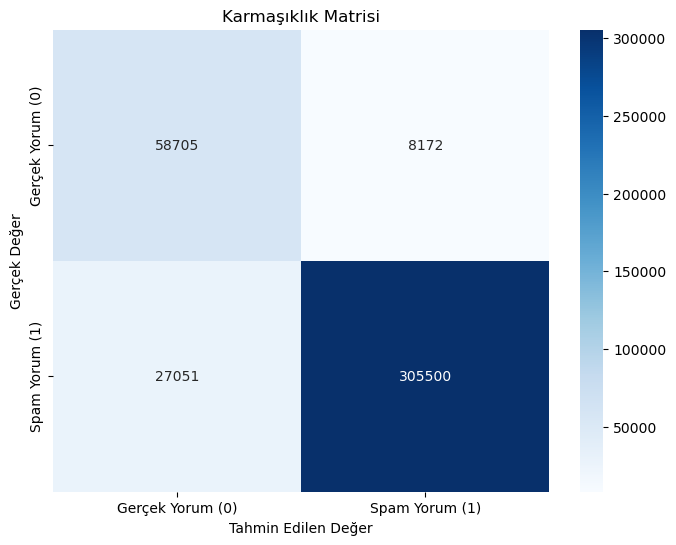

In [8]:
print("\nHiperparametre optimizasyonu tamamlandı.")
print("-" * 40)
print(f"En iyi F1 Skoru (Çapraz Doğrulama ile): {grid_search.best_score_:.4f}")
print("Bulunan En İyi Parametreler:")
print(grid_search.best_params_)
print("-" * 40)

# En iyi modeli al
best_model = grid_search.best_estimator_

# En iyi model ile Test seti üzerinde tahmin yap
y_pred = best_model.predict(X_test)

# Sınıflandırma Raporu
print("FİNAL TEST SETİ PERFORMANS RAPORU")
print(classification_report(y_test, y_pred, target_names=['Gerçek Yorum (0)', 'Spam Yorum (1)']))

# Karmaşıklık Matrisi (Confusion Matrix)
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Gerçek Yorum (0)', 'Spam Yorum (1)'],
            yticklabels=['Gerçek Yorum (0)', 'Spam Yorum (1)'])
plt.ylabel('Gerçek Değer')
plt.xlabel('Tahmin Edilen Değer')
plt.title('Karmaşıklık Matrisi')
plt.show()

The model achieved an overall accuracy of 91% and a cross-validated F1 score of 0.916, which indicates strong generalization performance.

The model performs very well on detecting spam reviews, with a precision of 0.97 and recall of 0.92.

The performance on genuine reviews is weaker in comparison, with precision = 0.68 and recall = 0.88.

Overall, the model is biased toward the majority class (spam), which is expected given the strong class imbalance in the dataset. The imbalance likely causes the model to favor predicting spam more confidently while misclassifying some real reviews.

To improve performance on the minority class (real comments), I will apply oversampling with SMOTE.

In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.impute import SimpleImputer

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

base_path = os.path.dirname(os.getcwd())
data_dir = os.path.join(base_path, "data", "processed", "Toys_and_Games")
DATA_PATH = os.path.join(data_dir, "toys_and_games.parquet")

data = pd.read_parquet(DATA_PATH)
print("Orijinal, dengesiz veri yeniden yüklendi.")

X = data.drop('class', axis=1)
y = data['class']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)
print(f"Veri {len(X_train)} satır eğitim, {len(X_test)} satır test olarak ayrıldı.")
print("Eğitim seti orijinal dağılımı:\n", y_train.value_counts())
print("-" * 40)


numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=0))
])
preprocessor = ColumnTransformer(
    transformers=[
        ('text', TfidfVectorizer(), 'cleaned_text'),
        ('numeric', numeric_transformer, ['overall', 'helpfulness_ratio'])
    ],
    remainder='drop' 
)

pipeline_combined = Pipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(sampling_strategy={0: 400000}, random_state=42)),
    ('rus', RandomUnderSampler(sampling_strategy={1: 1200000}, random_state=42)),
    ('model', MultinomialNB())
])


param_grid_focused = {
    'preprocessor__text__max_features': [15000], # Since it was the best choice last time
    'preprocessor__text__ngram_range': [(1, 2)],  # Since it was the best choice last time
    'model__alpha': [0.5, 1.0]
}


# --- 4. ADIM: GridSearchCV'Yİ DAHA HIZLI AYARLARLA ÇALIŞTIR ---
# cv=3 -> Daha az katman, daha hızlı çalışma
# n_jobs=4 -> RAM dostu bir paralel işlem sayısı
grid_search_combined = GridSearchCV(pipeline_combined, param_grid_focused, cv=3, scoring='f1_weighted', n_jobs=4, verbose=3)

print("Kombinasyon yöntemi ile hiperparametre optimizasyonu başlıyor...")
grid_search_combined.fit(X_train, y_train)


# --- 5. ADIM: SONUÇLARI İNCELE VE FİNAL TESTİ ---
print("\nHiperparametre optimizasyonu tamamlandı.")
print("-" * 40)
print(f"En iyi F1 Skoru (Çapraz Doğrulama ile): {grid_search_combined.best_score_:.4f}")
print("Bulunan En İyi Parametreler:")
print(grid_search_combined.best_params_)
print("-" * 40)

best_model_combined = grid_search_combined.best_estimator_
y_pred_combined = best_model_combined.predict(X_test)

print("FİNAL TEST SETİ PERFORMANS RAPORU (Kombinasyon Yöntemi)")
print(classification_report(y_test, y_pred_combined, target_names=['Gerçek Yorum (0)', 'Spam Yorum (1)']))

cm_combined = confusion_matrix(y_test, y_pred_combined)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_combined, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Gerçek Yorum (0)', 'Spam Yorum (1)'],
            yticklabels=['Gerçek Yorum (0)', 'Spam Yorum (1)'])
plt.ylabel('Gerçek Değer')
plt.xlabel('Tahmin Edilen Değer')
plt.title('Karmaşıklık Matrisi (Kombinasyon Yöntemi)')
plt.show()